# setting

In [1]:
!pip install -q pycaret --upgrade
!pip install -q scipy
!pip install -q markupsafe==2.1.1
!pip install -q optuna
!pip install -q pycaret[tuners]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 70.6 MB/s eta 0:00:00
   ━━

In [3]:
# 코랩 - 구글 드라이브 연결
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from pycaret.regression import *
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

In [5]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [6]:
# 난수 설정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

# load data

In [7]:
# 데이터셋 경로 설정
ROOT_DIR_GOOGLEDRIVE = '/content/drive/MyDrive/Contest/New-Medinine-Dev/'
ROOT_DIR_LOCAL = '..'

In [8]:
# 시각화 모듈 관련 설정
warnings.filterwarnings('ignore')           # 출력 창 경고 메시지 무시
plt.rcdefaults()
plt.rcParams['axes.unicode_minus'] = False  # 음수부호 깨짐 관련
# plt.rcParams['font.family'] = 'AppleGothic' # mac os 전용 한글 폰트 설정
# plt.rcParams['font.family'] = 'Malgun Gothic' # window 전용 한글 폰트 설정
plt.rcParams['font.family'] = 'sans-serif'
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib.font_manager')

In [9]:
dataset = pd.read_csv(f'{ROOT_DIR_GOOGLEDRIVE}/data/preprocessed/train_corr45.csv')
test_X = pd.read_csv(f'{ROOT_DIR_GOOGLEDRIVE}/data/preprocessed/test_corr45.csv')

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1926 entries, 0 to 1925
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pIC50                1926 non-null   float64
 1   NumValenceElectrons  1926 non-null   int64  
 2   Chi0                 1926 non-null   float64
 3   Chi0n                1926 non-null   float64
 4   Chi2n                1926 non-null   float64
 5   Kappa1               1926 non-null   float64
 6   fr_pyridine          1926 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 105.5 KB


In [11]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NumValenceElectrons  113 non-null    int64  
 1   Chi0                 113 non-null    float64
 2   Chi0n                113 non-null    float64
 3   Chi2n                113 non-null    float64
 4   Kappa1               113 non-null    float64
 5   fr_pyridine          113 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 5.4 KB


## 제거

In [12]:
dataset.drop(columns=['NumValenceElectrons'], inplace=True)
test_X.drop(columns=['NumValenceElectrons'], inplace=True)

In [13]:
# 1. 데이터 준비
setup_data = setup(
    data=dataset,
    target='pIC50',
    train_size=0.8, # validation
    session_id=42,  # random state
    n_jobs=-1,      # CPU 코어 개수-가능한 모든 CPU 코어 사용
    fold=5,         # 교차검증 폴더 수
)
'''
[ 파라미터 ]
- data : Input data를 입력해주시면 됩니다. Train, Test를 별도로 분리하지 않고 입력해주시면 뒤의 train_size에 입력한 비율대로 Train,Test를 split 합니다.
- target : 데이터셋에서 최종적으로 예측해야 하는 Column을 설정해주는 파라미터 입니다. data에서 지정해준 input data에 해당 column이 존재해야 가능합니다.
- session_id : Random seed를 설정해주는 부분입니다. 반복 실행을 진행 했을 때 동일한 결과를 나오도록 합니다.
- normalize : 데이터에 정규화를 할 것인지 True/False로 선택합니다.
- normalize_method : normalize를 True인 경우 어떤 방식으로 정규화를 진행할 것인지를 정합니다.('minmax','maxabs','robust')
- transformation : Power Transformation을 통해서 데이터 샘플들의 분포가 가우시안 분포(정규 분포)에 더 가까워지도록 처리해주는 과정입니다.
- fold_strategy : Fold starategy전략을 선택해서 설정할 수 있는 하이퍼파라미터 입니다. pycaret은 기본적으로 10-fold Cross-Validation을 수행합니다.
'''

,Description,Value
0,Session id,42
1,Target,pIC50
2,Target type,Regression
3,Original data shape,"(1926, 6)"
4,Transformed data shape,"(1926, 6)"
5,Transformed train set shape,"(1540, 6)"
6,Transformed test set shape,"(386, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


"\n[ 파라미터 ]\n- data : Input data를 입력해주시면 됩니다. Train, Test를 별도로 분리하지 않고 입력해주시면 뒤의 train_size에 입력한 비율대로 Train,Test를 split 합니다. \n- target : 데이터셋에서 최종적으로 예측해야 하는 Column을 설정해주는 파라미터 입니다. data에서 지정해준 input data에 해당 column이 존재해야 가능합니다.\n- session_id : Random seed를 설정해주는 부분입니다. 반복 실행을 진행 했을 때 동일한 결과를 나오도록 합니다.\n- normalize : 데이터에 정규화를 할 것인지 True/False로 선택합니다.\n- normalize_method : normalize를 True인 경우 어떤 방식으로 정규화를 진행할 것인지를 정합니다.('minmax','maxabs','robust')\n- transformation : Power Transformation을 통해서 데이터 샘플들의 분포가 가우시안 분포(정규 분포)에 더 가까워지도록 처리해주는 과정입니다.\n- fold_strategy : Fold starategy전략을 선택해서 설정할 수 있는 하이퍼파라미터 입니다. pycaret은 기본적으로 10-fold Cross-Validation을 수행합니다.\n"

# compare models

In [14]:
# 사용가능한 모델 확인
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [13]:
# 사용가능한 모델의 성능을 비교
compare_models()
'''
[ 파라미터 ]
- n_select :  학습에 수행한 모델을 n_select에서 설정해준 수만큼 성능 순서대로 모델을 저장해줍니다.
- sort : Metric의 이름을 입력해주시면 됩니다. 어떤 metric의 기준으로 성능을 sort할지 지정해줍니다.
- include : 어떤 모델들을 비교할지 설정해주는 함수 입니다. 여기서 특정 모델을 포함할 수 있습니다.
- exclude : include와 반대로 특정 모델을 제거하고 비교할 수 있습니다.
- fold : fold를 지정해줄 수 있습니다.
'''

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.5961,0.6694,0.8165,0.4341,0.1008,0.0843,0.3280
rf,Random Forest Regressor,0.5999,0.6710,0.8181,0.4320,0.1009,0.0849,0.5680
gbr,Gradient Boosting Regressor,0.6280,0.7203,0.8474,0.3882,0.1042,0.0887,0.2660
lightgbm,Light Gradient Boosting Machine,0.6293,0.7250,0.8505,0.3854,0.1045,0.0886,2.5800
xgboost,Extreme Gradient Boosting,0.6402,0.7694,0.8765,0.3472,0.1081,0.0902,0.2140
ridge,Ridge Regression,0.6735,0.7760,0.8797,0.3419,0.1079,0.0950,0.0420
lr,Linear Regression,0.6735,0.7761,0.8798,0.3419,0.1079,0.0950,1.5080
br,Bayesian Ridge,0.6736,0.7762,0.8799,0.3417,0.1080,0.0950,0.0260
huber,Huber Regressor,0.6736,0.7867,0.8859,0.3317,0.1085,0.0949,0.0560
knn,K Neighbors Regressor,0.6609,0.7992,0.8928,0.3227,0.1094,0.0935,0.0360


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

'\n[ 파라미터 ]\n- n_select :  학습에 수행한 모델을 n_select에서 설정해준 수만큼 성능 순서대로 모델을 저장해줍니다.\n- sort : Metric의 이름을 입력해주시면 됩니다. 어떤 metric의 기준으로 성능을 sort할지 지정해줍니다.\n- include : 어떤 모델들을 비교할지 설정해주는 함수 입니다. 여기서 특정 모델을 포함할 수 있습니다.\n- exclude : include와 반대로 특정 모델을 제거하고 비교할 수 있습니다.\n- fold : fold를 지정해줄 수 있습니다.\n'

In [15]:
# 모델 비교
ml_models = compare_models(sort='rmse', fold=5, n_select=5) # K-fold=5(1fold당 380개 가량 샘플)

# 파라미터
'''
pycaret.classification.compare_models(
    include: Optional[List[Union[str, Any]]] = None,  # 포함할 머신러닝 모델 유형
    exclude: Optional[List[str]] = None,              # 제외할 머신러닝 모델 유형
    fold: Optional[Union[int, Any]] = None,           # K-Fold, 교차 검증(k)
    round: int = 4,
    cross_validation: bool = True,
    sort: str = 'Accuracy',                           # 정렬 기준 스코어
    n_select: int = 1,                                # 반환할 top_n 모델 수
    budget_time: Optional[float] = None,
    turbo: bool = True,
    errors: str = 'ignore',
    ...
)
'''

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.6061,0.6987,0.8346,0.4081,0.1029,0.0857,0.2900
rf,Random Forest Regressor,0.6104,0.6987,0.8350,0.4081,0.1030,0.0864,0.5060
gbr,Gradient Boosting Regressor,0.6273,0.7186,0.8465,0.3904,0.1040,0.0885,0.2120
lightgbm,Light Gradient Boosting Machine,0.6407,0.7538,0.8678,0.3597,0.1068,0.0904,1.1040
knn,K Neighbors Regressor,0.6439,0.7771,0.8803,0.3432,0.1081,0.0913,0.0300
lr,Linear Regression,0.6736,0.7778,0.8807,0.3403,0.1080,0.0950,1.3840
ridge,Ridge Regression,0.6736,0.7777,0.8807,0.3403,0.1080,0.0950,0.0420
br,Bayesian Ridge,0.6738,0.7779,0.8808,0.3401,0.1080,0.0950,0.0260
huber,Huber Regressor,0.6706,0.7821,0.8831,0.3360,0.1080,0.0943,0.0580
xgboost,Extreme Gradient Boosting,0.6503,0.7982,0.8928,0.3228,0.1097,0.0917,0.1940


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

"\npycaret.classification.compare_models(\n    include: Optional[List[Union[str, Any]]] = None,  # 포함할 머신러닝 모델 유형\n    exclude: Optional[List[str]] = None,              # 제외할 머신러닝 모델 유형\n    fold: Optional[Union[int, Any]] = None,           # K-Fold, 교차 검증(k)\n    round: int = 4, \n    cross_validation: bool = True, \n    sort: str = 'Accuracy',                           # 정렬 기준 스코어\n    n_select: int = 1,                                # 반환할 top_n 모델 수\n    budget_time: Optional[float] = None, \n    turbo: bool = True, \n    errors: str = 'ignore', \n    ...\n)\n"

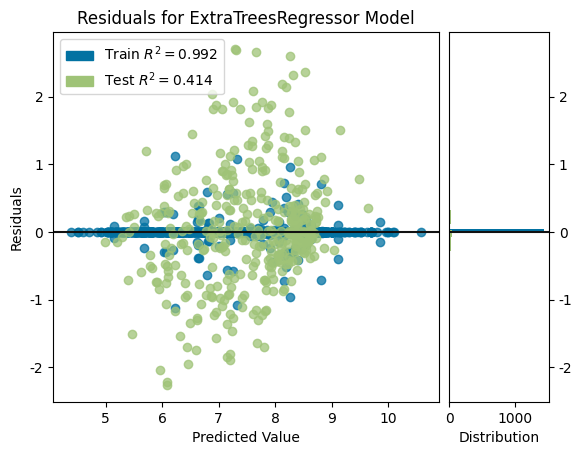

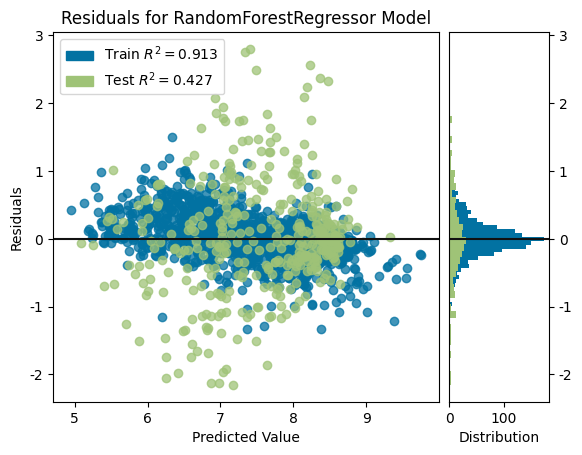

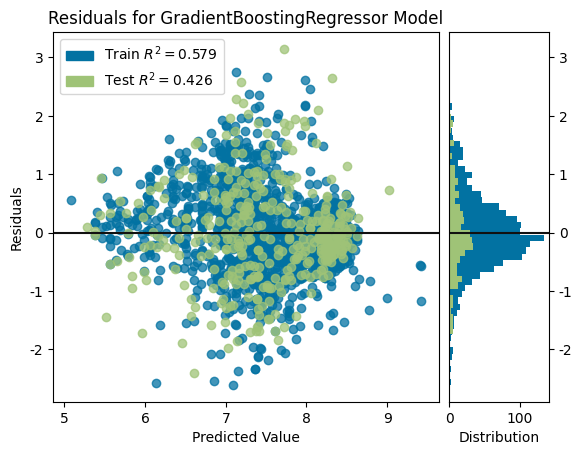

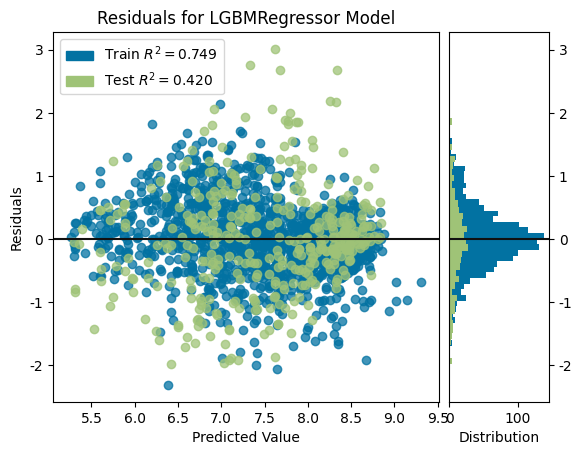

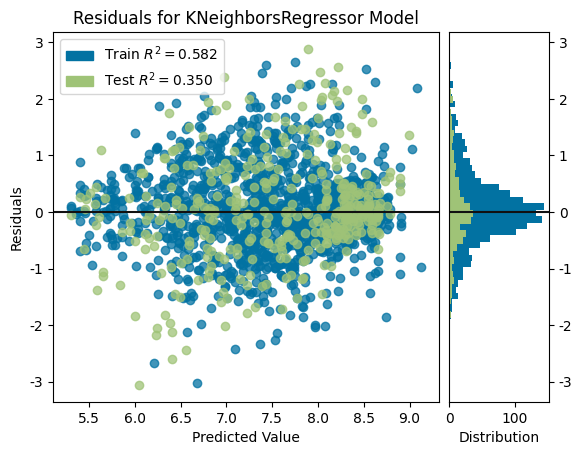

In [16]:
for model in ml_models:
    plot_model(model)

# 하이퍼파라미터 튜닝

lgmb, xgboost가 randomforest보다 성능이 낮음 -> dataset과 현재 model의 파라미터 세팅이 맞지 않는 경우일 수 있음 -> 파라미터 세팅 필요.

In [ ]:
# 모델 선택
# model = create_model('et')

In [17]:
# 모델 하이퍼파라미터 튜닝 (Ramdomized SerchCV와 같은 탐색 방법 사용함.)
# tuned_models = []
# for model in models:
#     print(f'튜닝 모델명 : {model}')
#     tuned_model = tune_model(
#         model,
#         n_iter=50,
#         optimize='RMSE',
#         search_library='optuna',
#         search_algorithm='tpe', #베이지안은 아니지만, 베이지안에 기반
#         early_stopping=True,
#         early_stopping_max_iters=10,
#         choose_better=True,
#         verbose=True,
#     )
#     tuned_models.append(tuned_model)

tuned_models = [tune_model(model, n_iter=150, optimize='rmse', search_library='optuna', search_algorithm='tpe', early_stopping=True, early_stopping_max_iters=10, choose_better=True) for model in ml_models]

'''
[ 파라미터 ]
n_iter : 탐색할 하이퍼파라미터 조합의 수, 값이 클수록 탐색시간이 길지만, 더 최적화 시킬 수 있음
- 30~50 : 초기 탐색
- 50~100 : 성능 개선
- 100 이상 : 최적 성능 탐색
optimize : 최적화할 평가 지표
search_library : 탐색 라이브러리(optuna가 속도도 빠르고 효율적으로 탐색 가능하다고 함.)
search_algorithm : 탐색 알고리즘(bayesian)
early_stopping : 학습 중단 여부,
early_stopping_max_iters : 성능 개선 없으면 10회 반복 . 후중단
choose_better : 튜닝후 성능이 낮아지면, 원래 모델 유지
verbose : 탐색 과정 출력 여부(2이면 상세정보 출력)
'''

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6139,0.7086,0.8418,0.4269,0.1045,0.0875
1,0.5649,0.5826,0.7633,0.5245,0.0946,0.0795
2,0.5559,0.5648,0.7515,0.4429,0.0902,0.0756
3,0.6570,0.8131,0.9017,0.3702,0.1127,0.0955
4,0.5778,0.6225,0.7890,0.4548,0.0976,0.0830
Mean,0.5939,0.6583,0.8095,0.4439,0.0999,0.0842
Std,0.0372,0.0919,0.0556,0.0497,0.0079,0.0069


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 1540 samples...
INFO:optuna_integration.sklearn.sklearn:Finished hyperparameter search!


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6286,0.7573,0.8702,0.3875,0.1079,0.0899
1,0.5780,0.6283,0.7927,0.4872,0.0975,0.0809
2,0.5785,0.6019,0.7758,0.4063,0.0930,0.0788
3,0.6566,0.7953,0.8918,0.3840,0.1109,0.0947
4,0.5997,0.6499,0.8062,0.4308,0.0989,0.0854
Mean,0.6083,0.6866,0.8273,0.4192,0.1016,0.0859
Std,0.0304,0.0758,0.0454,0.0379,0.0067,0.0058


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 1540 samples...
INFO:optuna_integration.sklearn.sklearn:Finished hyperparameter search!


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6435,0.7523,0.8674,0.3915,0.1076,0.0919
1,0.5967,0.6401,0.8000,0.4776,0.0985,0.0839
2,0.5974,0.6342,0.7964,0.3745,0.0957,0.0814
3,0.6596,0.7941,0.8911,0.3849,0.1110,0.0951
4,0.6057,0.6568,0.8104,0.4248,0.0998,0.0865
Mean,0.6206,0.6955,0.8331,0.4107,0.1025,0.0878
Std,0.0260,0.0652,0.0387,0.0375,0.0058,0.0051


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 1540 samples...
INFO:optuna_integration.sklearn.sklearn:Finished hyperparameter search!


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6392,0.7547,0.8688,0.3895,0.1083,0.0918
1,0.5814,0.5997,0.7744,0.5105,0.0957,0.0819
2,0.6036,0.6581,0.8113,0.3509,0.0974,0.0823
3,0.6702,0.8161,0.9034,0.3679,0.1126,0.0968
4,0.6222,0.6754,0.8218,0.4085,0.1011,0.0888
Mean,0.6233,0.7008,0.8359,0.4055,0.1030,0.0883
Std,0.0303,0.0760,0.0452,0.0560,0.0065,0.0057


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 1540 samples...
INFO:optuna_integration.sklearn.sklearn:Finished hyperparameter search!


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6468,0.7617,0.8728,0.3839,0.1085,0.0927
1,0.5738,0.6034,0.7768,0.5075,0.0968,0.0818
2,0.5823,0.6085,0.7801,0.3998,0.0936,0.0794
3,0.6573,0.7986,0.8937,0.3814,0.1114,0.0950
4,0.5664,0.6125,0.7826,0.4636,0.0970,0.0818
Mean,0.6053,0.6770,0.8212,0.4272,0.1015,0.0861
Std,0.0387,0.0851,0.0511,0.0500,0.0071,0.0064


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 1540 samples...
INFO:optuna_integration.sklearn.sklearn:Finished hyperparameter search!


'\n[ 파라미터 ]\nn_iter : 탐색할 하이퍼파라미터 조합의 수, 값이 클수록 탐색시간이 길지만, 더 최적화 시킬 수 있음\n- 30~50 : 초기 탐색\n- 50~100 : 성능 개선\n- 100 이상 : 최적 성능 탐색\noptimize : 최적화할 평가 지표\nsearch_library : 탐색 라이브러리(optuna가 속도도 빠르고 효율적으로 탐색 가능하다고 함.)\nsearch_algorithm : 탐색 알고리즘(bayesian)\nearly_stopping : 학습 중단 여부,\nearly_stopping_max_iters : 성능 개선 없으면 10회 반복 . 후중단\nchoose_better : 튜닝후 성능이 낮아지면, 원래 모델 유지\nverbose : 탐색 과정 출력 여부(2이면 상세정보 출력)\n'

In [18]:
# 각 모델별 파라미터 확인
for tuned_model in tuned_models:
    print(tuned_model)

ExtraTreesRegressor(max_depth=11, max_features=0.9495117630101347,
                    min_impurity_decrease=5.3663332313716726e-08,
                    n_estimators=139, n_jobs=-1, random_state=42)
RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features=0.7884305223244051,
                      min_impurity_decrease=6.052264007148862e-08,
                      min_samples_leaf=2, min_samples_split=3, n_estimators=49,
                      n_jobs=-1, random_state=42)
GradientBoostingRegressor(learning_rate=0.02067939580901327, max_depth=11,
                          max_features=0.48356572077956805,
                          min_impurity_decrease=0.08804168542455229,
                          min_samples_leaf=3, min_samples_split=6,
                          n_estimators=130, random_state=42,
                          subsample=0.33735687072235265)
LGBMRegressor(bagging_fraction=0.5835574842894681, bagging_freq=1,
              feature_fractio

In [19]:
# 검증셋 평가
for tuned_model in tuned_models:
    predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.6016,0.6593,0.8120,0.4647,0.1017,0.0867


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.6051,0.6714,0.8194,0.4548,0.1029,0.0874


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.6093,0.6536,0.8084,0.4693,0.1014,0.0878


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6131,0.6643,0.8151,0.4606,0.1023,0.0885


[LightGBM] [Warning] feature_fraction is set=0.630420002216535, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.630420002216535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.5835574842894681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5835574842894681


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,0.6259,0.7182,0.8474,0.4169,0.1061,0.0906


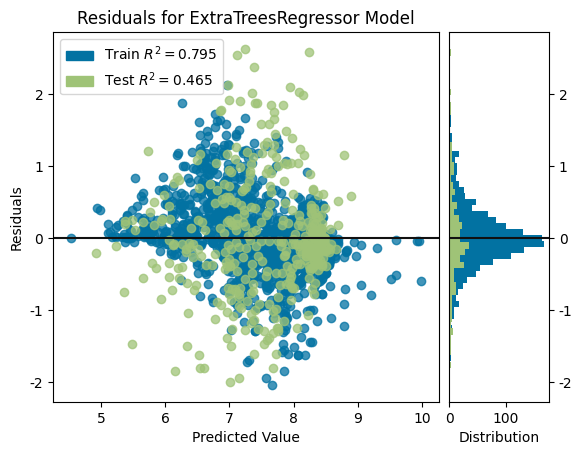

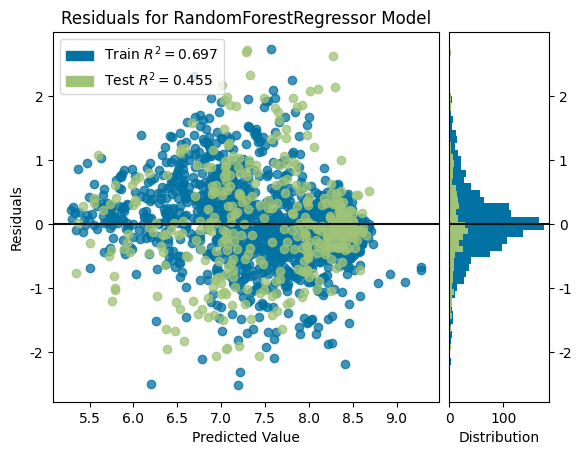

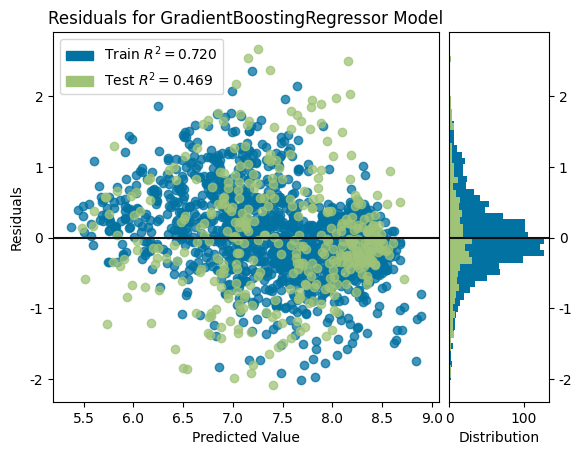

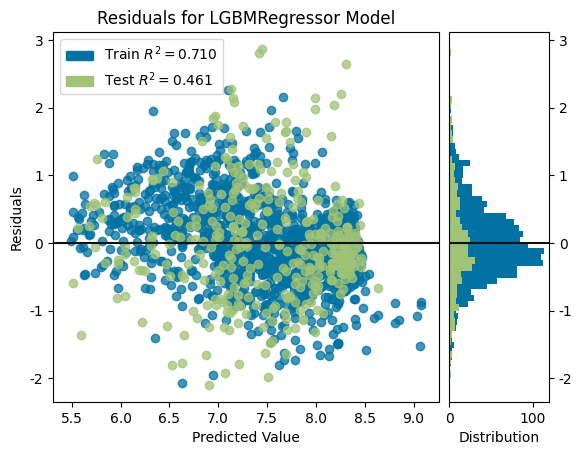

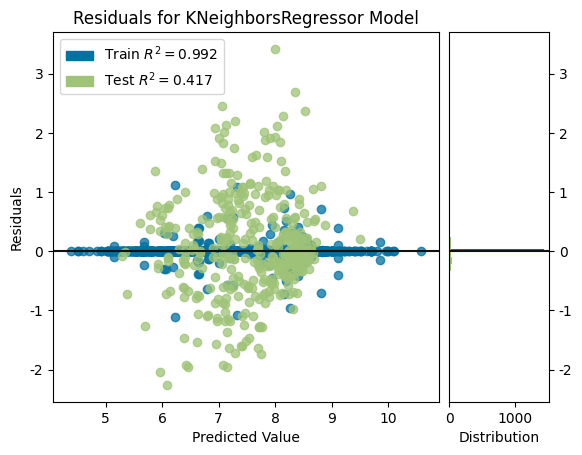

In [20]:
# 학습에 의해 예측된 값, 테스트에 의해 예측된 값 비교.
for tuned_model in tuned_models:
    plot_model(tuned_model)

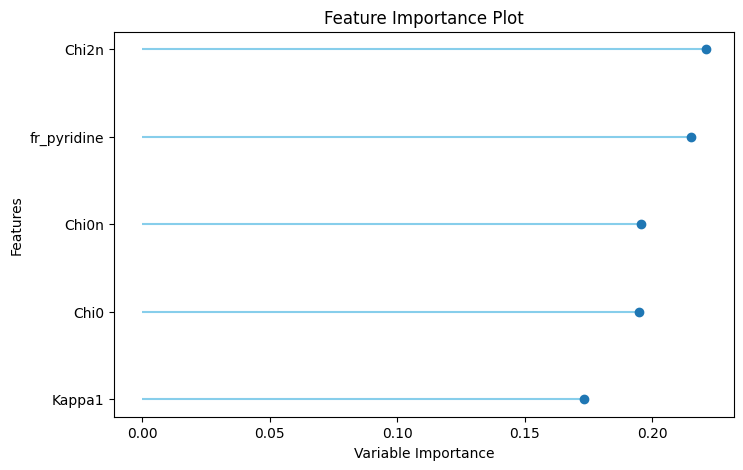

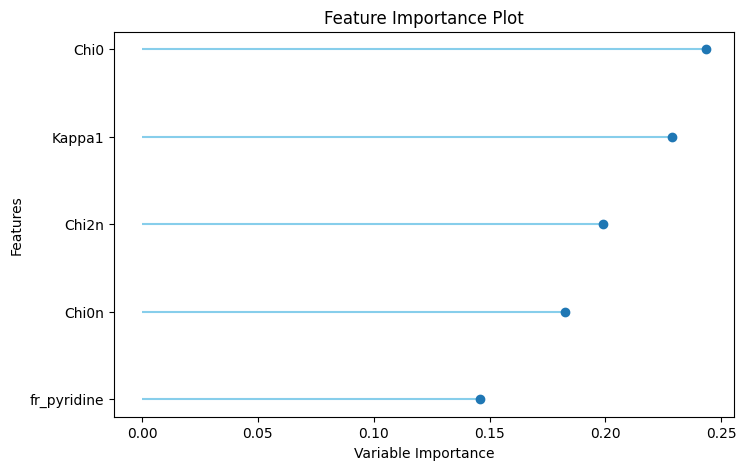

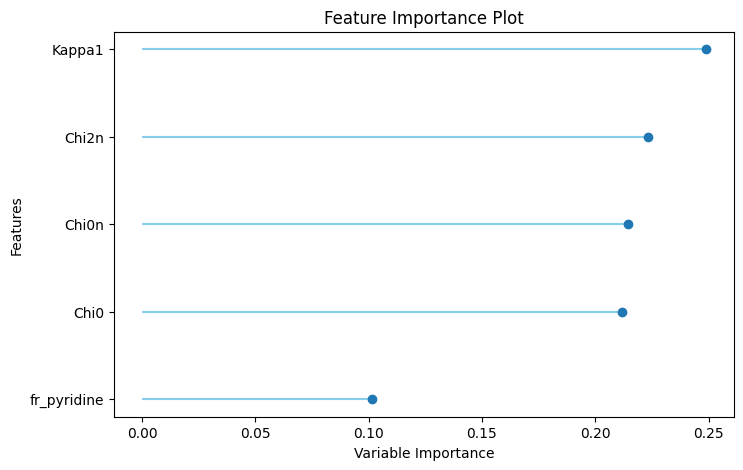

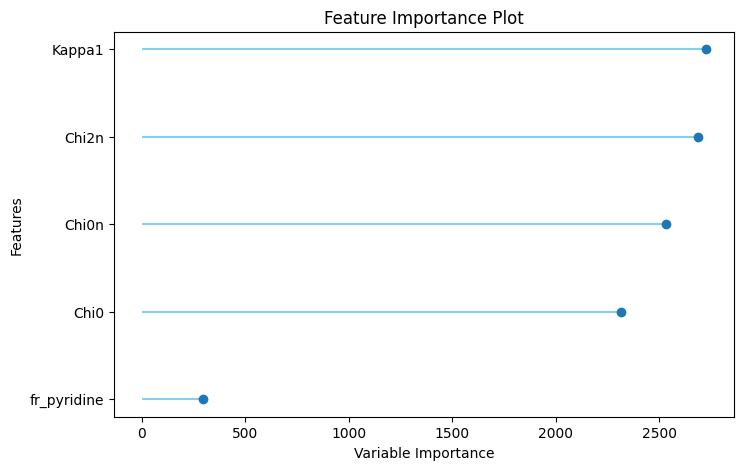

TypeError: Feature Importance and RFE plots not available for estimators that doesnt support coef_ or feature_importances_ attribute.

In [21]:
# 피처 중요도 시각화, 어떤 특성이 가장 큰 영향을 미쳤는지 파악
for tuned_model in tuned_models:
    plot_model(tuned_model, plot='feature')

# 앙상블 모델링

상관관계가 낮은 여러 모델을 ensemble한다면 좀더 일반화된 모델을 만들고 overfitting을 줄일 수 있음.

In [22]:
# 모델 앙상블(보팅기법)
blended = blend_models(
    estimator_list = tuned_models,
    fold = 10,
    optimize='rmse',
    choose_better=True,
    verbose=True,
)
'''
- estimatior_list :  사용하고자 하는 모델 리스트, 저의 경우 앞서 하이퍼파라미터 튜닝을 진행한 5개의 모델
- fold :  fold를 설정해주시면 됩니다.
- method :  soft와 hard가 있는데 soft가 성능이 좀 더 좋다고 합니다. task에 따라 다르니 둘다해보시면 좋을 것 같습니다.
- optimize :  평가하고자하는 metric을 지정해주시면 됩니다.
- choose_better :  튜닝후 모델 성능이 개별 모델보다 낮으면, 개별 모델 중 가장 성능 높은 모델 선택
- verbose :  탐색 과정 출력 여부
'''
# 앙상블 기법
# ensemble_model()

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5996,0.6265,0.7915,0.4255,0.0963,0.0827
1,0.6647,0.8428,0.9180,0.3850,0.1158,0.0983
2,0.5298,0.5279,0.7266,0.5045,0.0905,0.0749
3,0.5975,0.6294,0.7934,0.5442,0.0974,0.0840
4,0.6129,0.6725,0.8201,0.3793,0.0965,0.0811
5,0.5026,0.4610,0.6790,0.5021,0.0843,0.0710
6,0.5845,0.6903,0.8308,0.4318,0.1042,0.0848
7,0.7195,0.8639,0.9294,0.3672,0.1147,0.1031
8,0.5732,0.6015,0.7756,0.4884,0.0980,0.0855


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Original model was better than the blended model, hence it will be returned. NOTE: The display metrics are for the blended model (not the original one).


'\n- estimatior_list :  사용하고자 하는 모델 리스트, 저의 경우 앞서 하이퍼파라미터 튜닝을 진행한 5개의 모델\n- fold :  fold를 설정해주시면 됩니다.\n- method :  soft와 hard가 있는데 soft가 성능이 좀 더 좋다고 합니다. task에 따라 다르니 둘다해보시면 좋을 것 같습니다.\n- optimize :  평가하고자하는 metric을 지정해주시면 됩니다.\n- choose_better :  튜닝후 모델 성능이 개별 모델보다 낮으면, 개별 모델 중 가장 성능 높은 모델 선택\n- verbose :  탐색 과정 출력 여부\n'

In [23]:
# 모델 성능평가
final_model = finalize_model(blended)

# 모델 성능평가 인터페이스 제공
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

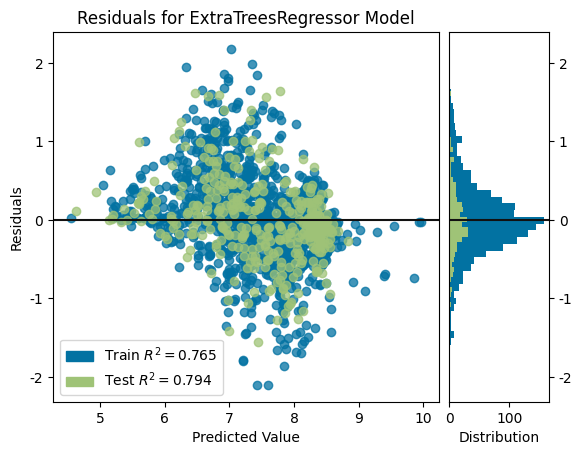

In [24]:
# 성능평가 시각화
plot_model(final_model)

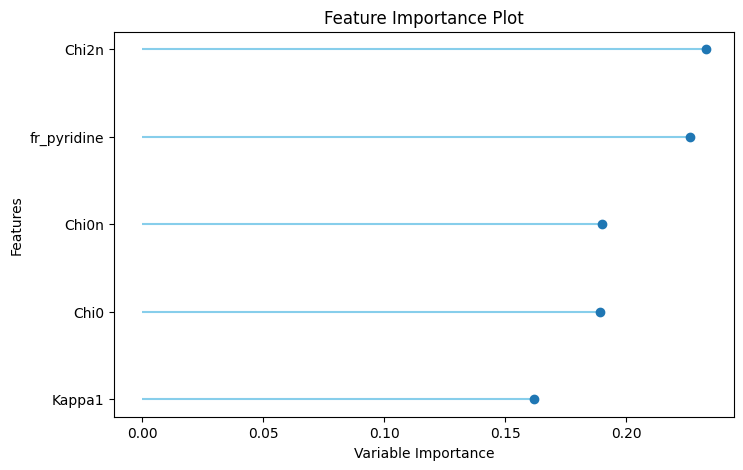

In [25]:
# 피처(특성) 중요도 시각화
plot_model(final_model, plot='feature')

---

# 검증

In [26]:
# pIC50에서 IC50을 계산하는 함수
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

# Normalized RMSE를 계산하는 함수
def calculate_normalized_rmse(true_pIC50, predicted_pIC50):
    """
    Normalized RMSE 계산.
    Normalized RMSE = RMSE / (max(true_IC50) - min(true_IC50))
    """
    # RMSE 계산
    mse = mean_squared_error(pIC50_to_IC50(true_pIC50), pIC50_to_IC50(predicted_pIC50))
    rmse = np.sqrt(mse)
    # Normalized RMSE 계산
    norm_rmse = rmse / (np.max(pIC50_to_IC50(true_pIC50)) - np.min(pIC50_to_IC50(predicted_pIC50)))
    return norm_rmse

# pIC50에서 Correct Ratio를 계산하는 함수
def calculate_correct_ratio(true_pIC50, predicted_pIC50):
    """
    Correct Ratio 계산.
    Correct Ratio = 1/N * Σ I(Absolute Error <= 0.5)
    """
    # 절대 오차 계산
    abs_errors = np.abs(predicted_pIC50 - true_pIC50)
    # 절대 오차가 0.5 이하인 경우의 수 계산
    correct_count = np.sum(abs_errors <= 0.5)
    # Correct Ratio 계산
    correct_ratio = correct_count / len(true_pIC50)
    return correct_ratio

# 최종 Score를 계산하는 함수
def calculate_score(true_pIC50, predicted_pIC50):
    """
    주어진 실제 IC50 값과 예측 IC50 값을 기반으로 Score 계산.
    Score = 0.5 * (1 - min(Normalized RMSE, 1)) + 0.5 * Correct Ratio
    """
    # Normalized RMSE 계산 (A 값)
    norm_rmse = calculate_normalized_rmse(true_pIC50, predicted_pIC50)

    # Correct Ratio 계산 (B 값)
    correct_ratio = calculate_correct_ratio(true_pIC50, predicted_pIC50)

    # 최종 Score 계산
    # Score = 0.5 * (1 - min(Normalized RMSE, 1)) + 0.5 * Correct Ratio
    score = 0.5 * (1 - min(norm_rmse, 1)) + 0.5 * correct_ratio

    return score

In [27]:
prediction = predict_model(final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3677,0.2534,0.5033,0.7943,0.0627,0.0519


In [28]:
prediction

,Chi0,Chi0n,Chi2n,Kappa1,fr_pyridine,pIC50,prediction_label
1075,25.354795,21.120733,9.681994,23.806170,0,7.66,7.480095
1650,20.501425,17.279093,8.426681,19.660376,0,6.16,6.760093
1861,15.689870,11.038589,4.508443,13.682035,0,5.35,5.325792
941,18.095648,14.591545,6.695149,16.524240,0,7.85,7.071854
331,23.233475,18.477337,9.152608,21.033442,0,8.52,7.914987
...,...,...,...,...,...,...,...
567,17.225405,13.774468,6.230345,15.589161,2,8.30,8.150117
720,22.716969,18.091166,8.349146,21.673330,2,8.12,8.276706
1921,27.760572,22.516346,10.488892,25.569405,1,4.58,4.929609
978,15.526733,13.542418,6.218752,15.032579,0,7.80,7.454059


In [29]:
# 검증 데이터셋의 실제 pIC50 값과 예측된 pIC50 값 추출
true_pIC50 = prediction['pIC50']
predicted_pIC50 = prediction['prediction_label']  # 예측된 pIC50 값 (Label 컬럼)

In [30]:
# 검증 데이터셋에 대한 성능 평가
final_score = calculate_score(true_pIC50, predicted_pIC50)
# 최종 성능 출력
print(f"Final Score on the Validation Set: {final_score}")

Final Score on the Validation Set: 0.8409725552538242


---

# Inference

In [31]:
# 테스트셋으로 모델 평가
prediction = predict_model(final_model, data=test_X)

In [32]:
prediction

,Chi0,Chi0n,Chi2n,Kappa1,fr_pyridine,prediction_label
0,23.329851,19.496742,9.190866,22.804060,1,7.844380
1,23.614309,19.820745,9.672890,21.808025,0,7.993902
2,21.045395,17.174862,7.982218,19.481529,0,6.742880
3,25.614309,20.560272,9.386562,24.463783,0,7.704356
4,22.622746,18.444916,8.737006,21.370140,0,7.060126
...,...,...,...,...,...,...
108,22.907202,18.891750,8.768039,20.837852,0,6.668840
109,28.061903,23.521307,10.970014,28.043972,1,6.684778
110,21.752502,17.881968,8.316769,20.424212,0,6.829843
111,21.371668,17.140673,7.789140,19.002108,0,6.949286


---

# Submission

In [33]:
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

In [34]:
submit = pd.read_csv('../content/drive/MyDrive/Contest/New-Medinine-Dev/data/original/sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(prediction['prediction_label'])
submit.head()

,ID,IC50_nM
0,TEST_000,14.309350
1,TEST_001,10.141410
2,TEST_002,180.767554
3,TEST_003,19.753497
4,TEST_004,87.071168


In [35]:
submit.to_csv('../content/drive/MyDrive/Contest/New-Medinine-Dev/submission/pycaret2_corr45_submit.csv', index=False)